In [5]:
using DrWatson
quickactivate(@__DIR__)

# Expand

Build upon the the methodology found in TimeCluster by [Ali et al](http://cs.swan.ac.uk/~csmark/publications/2019_TimeCluster.html)
but include all 300 flock agents.

A few different approaches are considered


In [2]:
using Flux, CSV, DataFrames, MLDataPattern, StatsBase, CUDA

using Plots

## Data Noramlisation and preperation

Normalise the data into the range [0, 1] as per the paper
We then create a sliding window using the defaults from the paper where stride = 1 and window_size = 60

In [6]:
df = DataFrame(CSV.File("$(datadir())/exp_raw/data.csv"; types=Float32))

function normalise(M) 
    min = minimum(minimum(eachcol(M)))
    max = maximum(maximum(eachcol(M)))
    return (M .- min) ./ (max - min)
end

normalised = Array(df) |> normalise

window_size = 60

data = slidingwindow(normalised',window_size,stride=1)

3393-element slidingwindow(adjoint(::Matrix{Float32}), 60, stride = 1) with eltype SubArray:
 [0.4964308 0.49547637 … 0.41529295 0.41362584; 0.21859932 0.21522745 … 0.08716341 0.08647672; … ; 0.52035177 0.51891536 … 0.4292123 0.42744172; 0.664805 0.6673311 … 0.80898935 0.8113594]
 [0.49547637 0.49449167 … 0.41362584 0.41195473; 0.21522745 0.21186176 … 0.08647672 0.08584033; … ; 0.51891536 0.51746523 … 0.42744172 0.4256551; 0.6673311 0.669851 … 0.8113594 0.81371814]
 [0.49449167 0.49347642 … 0.41195473 0.41028023; 0.21186176 0.2085063 … 0.08584033 0.08525832; … ; 0.51746523 0.5160018 … 0.4256551 0.42385238; 0.669851 0.6723637 … 0.81371814 0.8160656]
 [0.49347642 0.49243027 … 0.41028023 0.4085999; 0.2085063 0.20516114 … 0.08525832 0.08472662; … ; 0.5160018 0.51452553 … 0.42385238 0.4220337; 0.6723637 0.6748703 … 0.8160656 0.8184008]
 [0.49243027 0.49135324 … 0.4085999 0.40691563; 0.20516114 0.20182931 … 0.08472662 0.084243186; … ; 0.51452553 0.51303715 … 0.4220337 0.4201988; 0.6748703 0.

## Define the encoder and decoder

We can define the network shape in a couple of different ways:

- Keeping the convolution 1 dimensional and simply increasing the number of features from 3 to 900 (3 * num_of_agents) however this leads to impractical GPU memory usage if the same ratio of dimension expansion is used

- Using 2D convolution: ```window_size X num_of_agents x dimensions (3) x batch```

Lets try both approaches, adapting the 1d version to make it practical

In [57]:
# Adjusted the dimension expansion from ≈ 21x to 10x
# Also an aditional Conv/ConvTranspose step is added to reduce the dimensionality of the encoded
# space further

function create_ae_1d()
  # Define the encoder and decoder networks 
  encoder = Chain(
  # 60x900xb
  Conv((9,), 900 => 9000, relu; pad = SamePad()),
  MaxPool((2,)),
  # 30x9000xb
  Conv((5,), 9000 => 4500, relu; pad = SamePad()),
  MaxPool((2,)),
  # 15x4500xb
  Conv((5,),4500 => 2250, relu; pad = SamePad()),
  # 15x2250xb
  MaxPool((3,)),
  Conv((3,),2250 => 1000, relu; pad = SamePad()), # included an extra conv step
  # 5x1000xb
  Flux.flatten,
  Dense(5000,5000)
  )
decoder = Chain(
  (x -> reshape(x, 5,1000,:)),
  # 5x1000xb
  ConvTranspose((3,), 1000 => 2250, relu; pad = SamePad()),
  Upsample((3,)),
  # 15x2250xb
  ConvTranspose((5,), 2250 => 4500, relu; pad = SamePad()),
  Upsample((2,)),
  # 30x4500xb
  ConvTranspose((5,), 4500 => 9000, relu; pad = SamePad()),
  Upsample((2,)),
  # 60x9000xb
  ConvTranspose((9,), 9000 => 900, relu; pad = SamePad()),
  # 60x900xb
)
return (encoder, decoder)
end

create_ae_1d (generic function with 1 method)

In [ ]:
function create_ae_2d()
    # Define the encoder and decoder networks 
  encoder = Chain(
  # 60x300x3xb
    Conv((10,10), 3 => 64, relu; pad = SamePad()),
    MaxPool((2,2)),
    # 30x150x64xb
    Conv((5,5), 64 => 32, relu; pad = SamePad()),
    MaxPool((2,2)),
    # 15x75x32xb
    Conv((5,5),32 => 12, relu; pad = SamePad()),
    MaxPool((3,3)),
    # 5x25x12xb
    Flux.flatten,
    Dense(1500,1500)
    )
  decoder = Chain(
    (x -> reshape(x, 5,25,12,:)),
    # 5x25x12xb
    ConvTranspose((5,5), 12 => 32, relu; pad = SamePad()),
    Upsample((3,3)),
    # 15x75x32xb
    ConvTranspose((5,5), 32 => 64, relu; pad = SamePad()),
    Upsample((2,2)),
    # 30x150x64xb
    ConvTranspose((10,10), 64 => 3, relu; pad = SamePad()),
    Upsample((2,2))
    # 60x300x3xb
  )
  return (encoder, decoder)
 end

create_ae_2d (generic function with 1 method)

## Training
Training needs to be slightly adapted for each version of model we use

In [58]:
function train_model_1D!(model, data, opt; epochs=20, bs=16, dev=Flux.gpu)
    model = model |> dev
    ps = params(model)
    t = shuffleobs(data)
    local l
    losses = Vector{Float64}()
    for e in 1:epochs
        for x in eachbatch(t, size=bs)
            # bs[(900, 60)]
            x  = cat(x..., dims=3)
            # bs x 900 x 60
            x  = permutedims(x, [2,1,3])
            # 60 x 900 x bs
            gs = gradient(ps) do
                l = loss(model(x),x)
            end
            Flux.update!(opt, ps, gs)
        end
        l = round(l;digits=6)
        push!(losses, l)
        println("Epoch $e/$epochs - train loss: $l")
    end
    model = model |> cpu;
    losses
 end
    

train_model_1D! (generic function with 1 method)

In [14]:
function train_model_2D!(model, data, opt; epochs=20, bs=16, dev=Flux.gpu)
    model = model |> dev
    ps = params(model)
    t = shuffleobs(data)
    local l
    losses = Vector{Float64}()
    for e in 1:epochs
        for x in eachbatch(t, size=bs)
            # bs[(3, 60)]
            x  = cat(x..., dims=3)
            # bs x 900 x 60
            x = reshape(x, bs, 3, 300,60)
            # bs x 3 x 300 x 60
            x  = permutedims(x, [4,3,2,1])
            # 60 x 300 x 3 x bs
            gs = gradient(ps) do
              l = loss(model(x),x)
            end
            Flux.update!(opt, ps, gs)
        end
        l = round(l;digits=6)
        push!(losses, l)
        println("Epoch $e/$epochs - train loss: $l")
    end
    model = model |> cpu;
    losses
 end
    

train_model_2D! (generic function with 1 method)

In [59]:
loss(x,y)        = Flux.Losses.mse(x, y)

loss (generic function with 1 method)

In [15]:
encoder, decoder = create_ae_2d()
model            = Chain(encoder, decoder);
losses_2D_001 = train_model_2D!(model, data, Flux.Optimise.ADAM(0.001); epochs=20);

Epoch 1/20 - train loss: 0.189127


In [60]:
encoder, decoder = create_ae_1d()
model            = Chain(encoder, decoder);
#losses_01 = train_model!(model, data, Flux.Optimise.ADAM(0.001); epochs=20);


In [ ]:
PlotlyJS.plot(
    PlotlyJS.scatter(y=losses_01, x=1:20, mode="lines+markers")
, Layout(xaxis_title="Epoch", yaxis_title="Error"))

In [ ]:
!ls /

: 

Lets see how well it's able to reconstruct a random segment of the data

TODO: should use test data not training data

In [95]:
@userplot FlockPlot
@recipe function f(cp::FlockPlot)
    x, y, z = cp.args
    color := :black
    label --> false
    seriestype := :scatter
    alpha := 0.75
    markersize := 3
    xlim := (0, 1)
    ylim := (0, 1)
    zlim := (0, 1)
    x, y, z
end

function create_gif_from_raw(data)
    t = reshape(getobs(data),3,300,60)
    t = permutedims(t, [2,3,1])
    anim = @animate for i ∈ 1:60
        flockplot(t[:,i,1],t[:,i,2],t[:,i,3])
    end
    gif(anim, "anim_fps30.gif", fps = 30)
end


create_gif_from_raw (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = /Users/max/Documents/JuliaProjects/Swarm/notebooks/anim_fps30.gif
└ @ Plots /Users/max/.julia/packages/Plots/LSKOd/src/animation.jl:114


Plots.AnimatedGif("/Users/max/Documents/JuliaProjects/Swarm/notebooks/anim_fps30.gif")
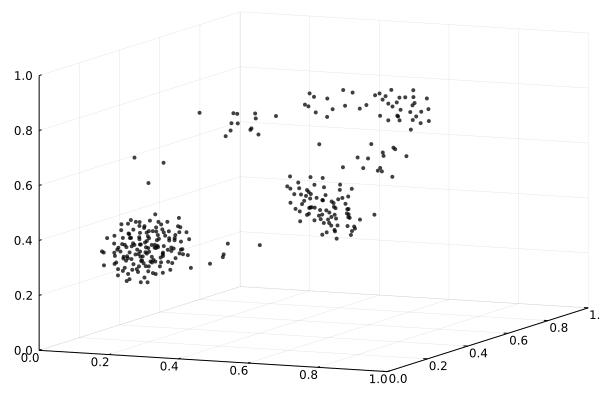

In [96]:
create_gif_from_raw(rand(data))

axes(input) = (Base.OneTo(60), Base.OneTo(900), Base.OneTo(1))


┌ Info: Saved animation to 
│   fn = /Users/max/Documents/JuliaProjects/Swarm/notebooks/anim_fps30.gif
└ @ Plots /Users/max/.julia/packages/Plots/LSKOd/src/animation.jl:114


Plots.AnimatedGif("/Users/max/Documents/JuliaProjects/Swarm/notebooks/anim_fps30.gif")
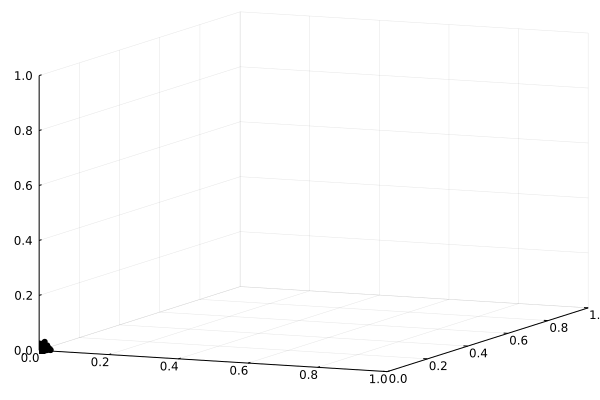

In [73]:
input = Flux.unsqueeze(rand(data)', 3)
@show axes(input)
output = model(input)
output = reshape(output, 60,900)'
create_gif_from_raw(output)

In [10]:
using CSV, DataFrames
df = DataFrame(CSV.File("/Users/max/trainging_data.txt"))

Row,training,validation
,Float64,Float64
1,0.430836,0.057712
2,0.055009,0.051833
3,0.053515,0.051719
4,0.053483,0.051669
5,0.053481,0.051648
6,0.05348,0.051622
7,0.053478,0.051622
8,0.053471,0.051615
9,0.053464,0.051602


In [12]:
using Pkg;
Pkg.add("Plotly")

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


   Installed PlotlyBase ──── v0.5.4
   Installed Mocking ─────── v0.7.5
   Installed InlineStrings ─ v1.3.1


   Installed StatsFuns ───── v0.9.7
   Installed DataAPI ─────── v1.13.0
   Installed ChainRules ──── v1.45.0


   Installed Plots ───────── v1.36.1
   Installed ForwardDiff ─── v0.10.33
   Installed FillArrays ──── v0.12.8


   Installed PlotlyJS ────── v0.14.1


   Installed WebIO ───────── v0.8.19
   Installed Distributions ─ v0.25.45


    Updating `~/Swarm/Project.toml`
⌃ [634d3b9d] ↓ DrWatson v2.12.0 ⇒ v2.5.0
⌃ [58dd65bb] + Plotly v0.3.0
⌅ [a03496cd] ↓ PlotlyBase v0.8.19 ⇒ v0.5.4
⌅ [f0f68f2c] ↓ PlotlyJS v0.18.10 ⇒ v0.14.1
  [91a5bcdd] ↑ Plots v1.36.0 ⇒ v1.36.1
  [0f1e0344] ↑ WebIO v0.8.18 ⇒ v0.8.19
    Updating `~/Swarm/Manifest.toml`


  [082447d4] ↑ ChainRules v1.44.7 ⇒ v1.45.0
  [9a962f9c] ↑ DataAPI v1.12.0 ⇒ v1.13.0
⌃ [31c24e10] ↓ Distributions v0.25.77 ⇒ v0.25.45
⌅ [ffbed154] ↓ DocStringExtensions v0.9.2 ⇒ v0.8.6
⌃ [634d3b9d] ↓ DrWatson v2.12.0 ⇒ v2.5.0
⌅ [1a297f60] ↓ FillArrays v0.13.5 ⇒ v0.12.8
  [f6369f11] ↑ ForwardDiff v0.10.32 ⇒ v0.10.33
⌃ [0c68f7d7] ↓ GPUArrays v8.5.0 ⇒ v8.3.2
  [842dd82b] ↑ InlineStrings v1.3.0 ⇒ v1.3.1
  [033835bb] - JLD2 v0.4.26
  [78c3b35d] ↑ Mocking v0.7.2 ⇒ v0.7.5
  [d96e819e] - Parameters v0.12.3
⌃ [995b91a9] ↓ PlotUtils v1.3.1 ⇒ v1.2.0
⌃ [58dd65bb] + Plotly v0.3.0
⌅ [a03496cd] ↓ PlotlyBase v0.8.19 ⇒ v0.5.4
⌅ [f0f68f2c] ↓ PlotlyJS v0.18.10 ⇒ v0.14.1
  [91a5bcdd] ↑ Plots v1.36.0 ⇒ v1.36.1
⌅ [189a3867] ↓ Reexport v1.2.2 ⇒ v0.2.0
⌅ [4c63d2b9] ↓ StatsFuns v0.9.18 ⇒ v0.9.7
  [0f1e0344] ↑ WebIO v0.8.18 ⇒ v0.8.19
⌃ [e88e6eb3] ↓ Zygote v0.6.49 ⇒ v0.6.41
⌅ [f7e6163d] ↓ Kaleido_jll v0.2.1+0 ⇒ v0.1.0+0
        Info Packages marked with ⌃ and ⌅ have new versions available, but those with ⌅ are r

    Building WebIO ───→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/55ea1b43214edb1f6a228105a219c6e84f1f5533/build.log`


    Building PlotlyJS → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/b859551864853bb2c317d0937e94bd19d749396b/build.log`


Precompiling project...


  ✓ LearnBase


  ✓ UnPack
  ✓ WoodburyMatrices


  ✓ PDMats
  ✓ Pipe
  ✓ TensorCore


  ✓ GroupSlices


  ✓ URIParser


  ✓ Contour
  ✓ Combinatorics


  ✓ IterTools
  ✓ Measures


  ✓ RecipesBase
  ✓ Grisu
  ✓ Observables


  ✓ Reexport


  ✓ Unzip
  ✓ IniFile


  ✓ Pidfile
  ✓ Distances


  ✓ DocStringExtensions


  ✓ PCRE2_jll


  ✓ BitIntegers


  ✓ FillArrays
  ✓ Ratios
  ✓ UnicodeFun


  ✓ ArrowTypes
  ✓ InlineStrings
  ✓ Hiccup
  ✓ DataAPI


  ✓ Inflate
  ✓ Scratch


  ✓ BSON


  ✓ MappedArrays
  ✓ FunctionalCollections
  ✓ DensityInterface


  ✓ FixedPointNumbers


  ✓ OpenSoundControl
  ✓ Mocking


  ✓ DataValues
  ✓ OpenSSL_jll


  ✓ Kaleido_jll
  ✓ Graphite2_jll


  ✓ Libmount_jll


  ✓ Bzip2_jll
  ✓ InterProcessCommunication


  ✓ Lz4_jll
  ✓ SimpleTraits
  ✓ Rmath_jll


  ✓ MbedTLS
  ✓ Lazy
  ✓ Xorg_libXau_jll


  ✓ libpng_jll
  ✓ libfdk_aac_jll
  ✓ OffsetArrays


  ✓ IntelOpenMP_jll
  ✓ LAME_jll


  ✓ Pixman_jll


  ✓ LERC_jll
  ✓ fzf_jll


  ✓ JpegTurbo_jll
  ✓ Ogg_jll
  ✓ Xorg_libXdmcp_jll


  ✓ x265_jll
  ✓ x264_jll


  ✓ libaom_jll


  ✓ Zstd_jll
  ✓ Expat_jll


  ✓ LZO_jll


  ✓ Arpack_jll
  ✓ Opus_jll
  ✓ Xorg_xtrans_jll
  ✓ Libiconv_jll


  ✓ Libffi_jll


  ✓ BinaryProvider
  ✓ Libgpg_error_jll
  ✓ Latexify
  ✓ Wayland_protocols_jll
  ✓ FileIO


  ✓ FFTW_jll
  ✓ Xorg_libpthread_stubs_jll


  ✓ Libuuid_jll
  ✓ FriBidi_jll


  ✓ AxisAlgorithms


  ✓ Showoff


  ✓ AssetRegistry


  ✓ QuadGK


  ✓ PooledArrays


  ✓ Missings
  ✓ RelocatableFolders
  ✓ BinDeps


  ✓ Tables


  ✓ FreeType2_jll


  ✓ WeakRefStrings


  ✓ FiniteDiff


  ✓ HDF5_jll


  ✓ CodecLz4
  ✓ LogExpFunctions


  ✓ NearestNeighbors
  ✓ MKL_jll


  ✓ libvorbis_jll
  ✓ Rmath
  ✓ ArnoldiMethod
  ✓ JLFzf


  ✓ Blosc_jll


  ✓ Libtiff_jll
  ✓ PlotlyBase


  ✓ XML2_jll
  ✓ GPUArrays
  ✓ Libgcrypt_jll


  ✓ CodecZstd
  ✓ Dierckx
  ✓ Arpack


  ✓ Mustache


  ✓ TableOperations
  ✓ ColorTypes


  ✓ Fontconfig_jll


  ✓ StructArrays


  ✓ DrWatson


  ✓ Blosc


  ✓ Wayland_jll
  ✓ HTTP


  ✓ Gettext_jll


  ✓ TimeZones
  ✓ XSLT_jll


  ✓ Glib_jll


  ✓ BangBang


  ✓ WebSockets
  ✓ Xorg_libxcb_jll


  ✓ StatsBase


  ✓ Interpolations
  ✓ Xorg_xcb_util_jll


  ✓ Xorg_libX11_jll


  ✓ MicroCollections


  ✓ Xorg_xcb_util_image_jll


  ✓ Xorg_xcb_util_keysyms_jll
  ✓ MLLabelUtils


  ✓ Mux


  ✓ Xorg_xcb_util_renderutil_jll
  ✓ Xorg_xcb_util_wm_jll


  ✓ MultivariateStats


  ✓ SpecialFunctions


  ✓ Xorg_libXrender_jll


  ✓ CSV
  ✓ Xorg_libXext_jll
  ✓ Intervals


  ✓ Xorg_libXfixes_jll


  ✓ Xorg_libxkbfile_jll


  ✓ FFTW


  ✓ Arrow


  ✓ Libglvnd_jll
  ✓ Clustering


  ✓ Xorg_libXinerama_jll
  ✓ DiffRules


  ✓ Colors


  ✓ HDF5
  ✓ Xorg_libXrandr_jll


  ✓ LightGraphs
  ✓ Xorg_libXcursor_jll


  ✓ Graphs
  ✓ Xorg_libXi_jll


  ✓ Xorg_xkbcomp_jll


  ✓ MLDataPattern


  ✓ StatsFuns


  ✓ PrettyTables


  ✓ GLFW_jll
  ✓ Xorg_xkeyboard_config_jll


  ✓ H5Zblosc


  ✓ xkbcommon_jll
  ✓ Cairo_jll


  ✓ Widgets


  ✓ Legolas


  ✓ Transducers
  ✓ ChainRules


  ✓ Qt5Base_jll


  ✓ ColorVectorSpace


  ✓ HarfBuzz_jll


  ✓ NearestNeighborDescent


  ✓ ManifoldLearning
  ✓ Polynomials


  ✓ libass_jll


  ✓ JLD


  ✓ LegolasFlux
  ✓ FoldsThreads


  ✓ WebIO


  ✓ FFMPEG_jll


  ✓ ForwardDiff


  ✓ JSExpr


  ✓ FFMPEG


  ✓ Distributions


  ✓ NLSolversBase


  ✓ DSP


  ✓ GR_jll


  ✓ ColorSchemes


  ✓ FLoops


  ✓ OptimBase
  ✓ Blink


  ✓ KernelDensity


  ✓ GR


  ✓ PlotUtils


  ✓ LsqFit


  ✓ Zygote


  ✓ UMAP


  ✓ MLUtils


  ✓ RecipesPipeline


  ✓ PlotThemes


  ✓ PlotlyJS


  ✓ OneHotArrays


  ✓ DataFrames


  ✓ Plotly


  ✓ CUDA


  ✓ NNlibCUDA


  ✓ Flux


  ✓ Plots


  ✓ EntropyHub


  ✓ StatsPlots
  216 dependencies successfully precompiled in 86 seconds. 81 already precompiled.
  10 dependencies precompiled but different versions are currently loaded. Restart julia to access the new versions


┌ Warning: Module Reexport with build ID 229272172102535 is missing from the cache.
│ This may mean Reexport [189a3867-3050-52da-a836-e630ba90ab69] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325


┌ Warning: Module Reexport with build ID 229272172102535 is missing from the cache.
│ This may mean Reexport [189a3867-3050-52da-a836-e630ba90ab69] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325


┌ Warning: Module Reexport with build ID 229272172102535 is missing from the cache.
│ This may mean Reexport [189a3867-3050-52da-a836-e630ba90ab69] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325


┌ Warning: Module Reexport with build ID 229272172102535 is missing from the cache.
│ This may mean Reexport [189a3867-3050-52da-a836-e630ba90ab69] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325


┌ Warning: Module Reexport with build ID 229272172102535 is missing from the cache.
│ This may mean Reexport [189a3867-3050-52da-a836-e630ba90ab69] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325


┌ Warning: Module Reexport with build ID 229272172102535 is missing from the cache.
│ This may mean Reexport [189a3867-3050-52da-a836-e630ba90ab69] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325


┌ Warning: Module Reexport with build ID 229272172102535 is missing from the cache.
│ This may mean Reexport [189a3867-3050-52da-a836-e630ba90ab69] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325


┌ Warning: Module Reexport with build ID 229272172102535 is missing from the cache.
│ This may mean Reexport [189a3867-3050-52da-a836-e630ba90ab69] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325


┌ Warning: Module Reexport with build ID 229272172102535 is missing from the cache.
│ This may mean Reexport [189a3867-3050-52da-a836-e630ba90ab69] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325


┌ Warning: Module WebIO with build ID 492022549500483 is missing from the cache.
│ This may mean WebIO [0f1e0344-ec1d-5b48-a673-e5cf874b6c29] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325


┌ Warning: Module Reexport with build ID 229272172102535 is missing from the cache.
│ This may mean Reexport [189a3867-3050-52da-a836-e630ba90ab69] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325


┌ Warning: Module Tables with build ID 229287155083002 is missing from the cache.
│ This may mean Tables [bd369af6-aec1-5ad0-b16a-f7cc5008161c] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325


In [13]:

using PlotlyJS

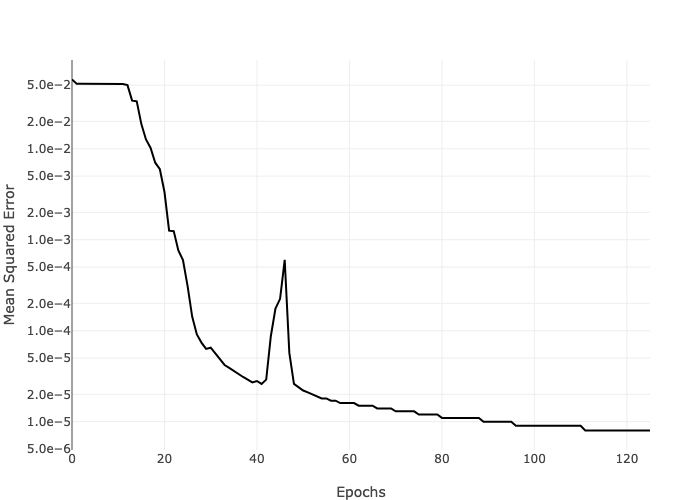

In [115]:

b = scatter(y = df[!,:validation], mode="lines", line=attr(color="black"), name="validation loss")


layout = Layout(
    xaxis_title = "Epochs",
    yaxis_type="log",
    yaxis=attr(
        tickmode="auto",
        nticks=7,
        tickformat=".1e",
        rangemode="tozero",
        title_text = "Mean Squared Error",
        title_standoff = 5,
        automargin=true,
        minor=(
            nticks = 5
        )
        ),
    yaxis_range=[log10(0), log10(1)]
)
plot([b], layout)